In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [1]:
#!pip install mne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        clear_output(wait=True)
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        clear_output(wait=True)
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

In [40]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(1,80)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 237 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
3555 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3555 events and 641 original time points ...
16 bad epochs dropped


(array([[    672,       0,       1],
        [   2000,       0,       0],
        [   3328,       0,       0],
        ...,
        [4676928,       0,       1],
        [4678256,       0,       0],
        [4679584,       0,       1]]),
 {'T1': 0, 'T2': 1})

In [41]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)
X = X[:,:,:]
X.shape

(3539, 64, 641) (3539,)


(3539, 64, 641)

In [42]:
# pick 7 channels.
#2 = X[:, :14, :]
# = X2

# pick C3 and C4 channels.
#2 = X[:, 1:2, :] 
#3= X[:, 5:6, :]
#4 = np.concatenate((X2,X3), axis=1)
# = X4

print(X.shape)

(3539, 64, 641)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape)

(2477, 64, 641) (2477,)


In [44]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [45]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(82048, 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [51]:
net = ConvNet().cuda(1)

In [52]:
# Loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0000001)
criterion = nn.CrossEntropyLoss()

In [53]:
# Train the model
num_epochs = 4000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if valid_accuracy[-1] > old_acc :
        torch.save(net.state_dict(), 'model_2class')
        old_acc = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 1/4000, Tr Loss: 0.7540, Tr Acc: 49.2935, Val Loss: 0.6922, Val Acc: 52.7307
Epoch 51/4000, Tr Loss: 0.7098, Tr Acc: 53.5729, Val Loss: 0.6954, Val Acc: 52.7307
Epoch 101/4000, Tr Loss: 0.6993, Tr Acc: 55.2281, Val Loss: 0.6890, Val Acc: 54.8964
Epoch 151/4000, Tr Loss: 0.6983, Tr Acc: 55.1070, Val Loss: 0.6795, Val Acc: 58.9454
Epoch 201/4000, Tr Loss: 0.6785, Tr Acc: 59.3460, Val Loss: 0.6749, Val Acc: 60.9228
Epoch 251/4000, Tr Loss: 0.6686, Tr Acc: 58.3367, Val Loss: 0.6644, Val Acc: 62.8060
Epoch 301/4000, Tr Loss: 0.6563, Tr Acc: 62.0509, Val Loss: 0.6548, Val Acc: 65.2542
Epoch 351/4000, Tr Loss: 0.6374, Tr Acc: 64.4328, Val Loss: 0.6436, Val Acc: 66.4783
Epoch 401/4000, Tr Loss: 0.6243, Tr Acc: 66.7339, Val Loss: 0.6340, Val Acc: 68.5499
Epoch 451/4000, Tr Loss: 0.6113, Tr Acc: 67.6625, Val Loss: 0.6194, Val Acc: 69.1149
Epoch 501/4000, Tr Loss: 0.5894, Tr Acc: 70.5289, Val Loss: 0.6099, Val Acc: 69.5857
Epoch 551/4000, Tr Loss: 0.5735, Tr Acc: 71.5381, Val Loss: 0.5947, 

In [57]:
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 4000/4000, Tr Loss: 0.2648, Tr Acc: 89.2208, Val Loss: 0.4224, Val Acc: 78.5311


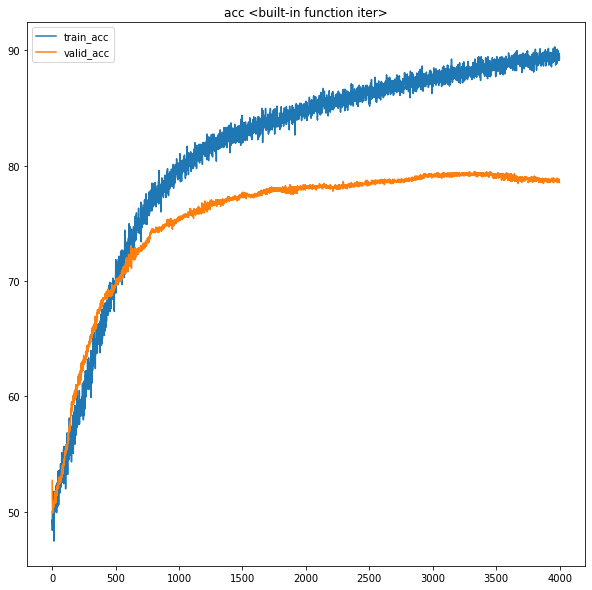

In [55]:
do_plot(train_accuracy, valid_accuracy,"acc")

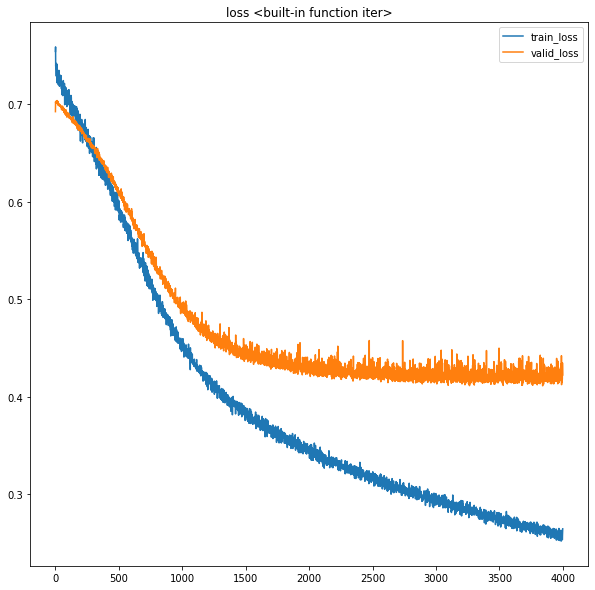

In [56]:
do_plot(train_loss, valid_loss,"loss")

### validate


In [86]:
net.load_state_dict(torch.load('model_2class'))

<All keys matched successfully>

In [87]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)

Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [88]:
X_val, y_val = eeg.get_X_y()

print(X.shape, y.shape)

X_val = X_val[:,:,:]
X_val.shape

(45, 64, 641) (45,)


(45, 64, 641)

In [89]:
test_loader = create_dataloader(X_val, y_val, batch_size=batch_size)

In [90]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 66.6667


### Freeze layer

In [91]:
net.load_state_dict(torch.load('model_2class'))

<All keys matched successfully>

In [92]:
parms = net.state_dict()
parms.keys()

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [93]:
for name,param in net.named_parameters():
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = False
    if param.requires_grad and 'layer2' in name:
        param.requires_grad = False

In [94]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)

Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [95]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:,:,:]
X.shape

(45, 64, 641) (45,)


(45, 64, 641)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(36, 64, 641) (36,)


In [97]:
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [98]:
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=0.000001)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.1)
#optimizer = optim.Adam(net.parameters(), lr=0.0000001)
criterion = nn.CrossEntropyLoss()

In [99]:
# Train the model
num_epochs = 1000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()
    
    for i, (items, classes) in enumerate(train_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs, classes)
        #print(outputs)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(loss)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
    if valid_accuracy[-1] > old_acc :
        torch.save(net.state_dict(), 'model_find_tune_2class_64ch')
        old_acc = valid_accuracy[-1]
    if (epoch%50) == 0 :
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))


Epoch 1/1000, Tr Loss: 6.7116, Tr Acc: 61.1111, Val Loss: 133.7369, Val Acc: 66.6667
Epoch 51/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 2.3474, Val Acc: 88.8889
Epoch 101/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0003, Val Acc: 100.0000
Epoch 151/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0004, Val Acc: 100.0000
Epoch 201/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0004, Val Acc: 100.0000
Epoch 251/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0002, Val Acc: 100.0000
Epoch 301/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0001, Val Acc: 100.0000
Epoch 351/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0002, Val Acc: 100.0000
Epoch 401/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0001, Val Acc: 100.0000
Epoch 451/1000, Tr Loss: 0.0000, Tr Acc: 100.0000, Val Loss: 0.0001, Val Acc: 100.0000
Epoch 501/1000, Tr Loss: 0.0003, Tr Acc: 100.0000, Val Loss: 0.0001, Val Acc: 100.0000
Epoch 551/1000, Tr Loss: 0.0000, Tr Acc: 100.00

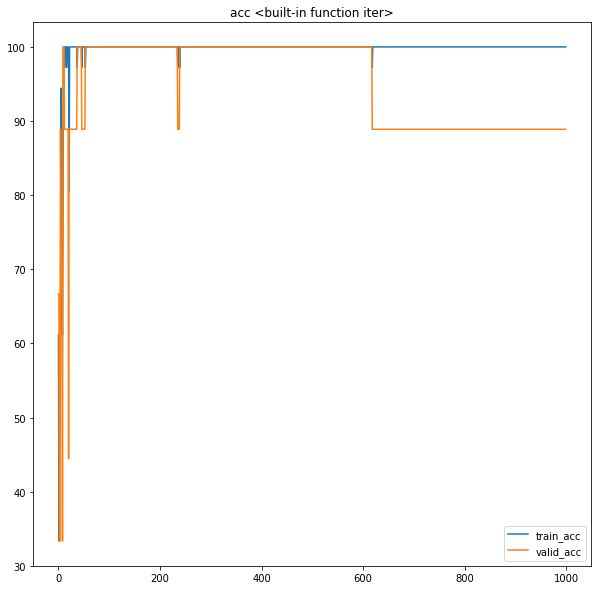

In [100]:
do_plot(train_accuracy, valid_accuracy,"acc")

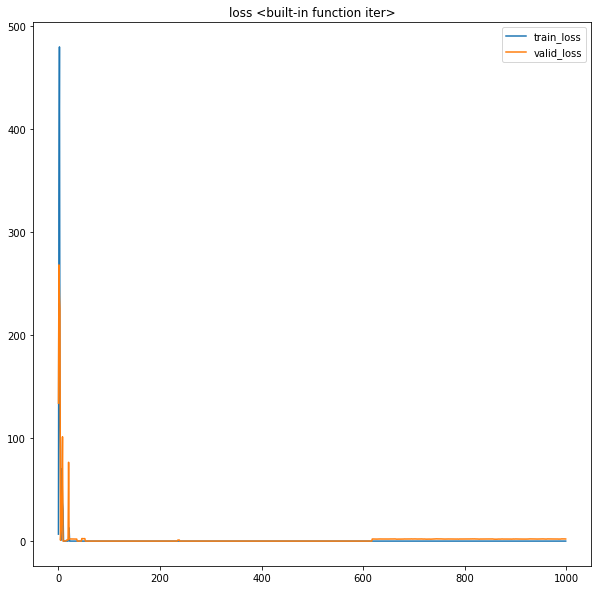

In [101]:
do_plot(train_loss, valid_loss,"loss")

### Validate Findtune

In [102]:
del net

In [103]:
net = ConvNet().cuda(1)

In [105]:
net.load_state_dict(torch.load('model_find_tune_2class_64ch'))

<All keys matched successfully>

In [106]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [4, 8, 12]
subjects = [i for i in range(83,84)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print("Raw done")
# apply filter
freq = (1., 40.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
eeg.create_epochs()

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filter done
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


(array([[  672,     0,     0],
        [ 2000,     0,     1],
        [ 3328,     0,     1],
        [ 4656,     0,     0],
        [ 5984,     0,     0],
        [ 7312,     0,     1],
        [ 8640,     0,     1],
        [ 9968,     0,     0],
        [11296,     0,     1],
        [12624,     0,     0],
        [13952,     0,     1],
        [15280,     0,     0],
        [16608,     0,     1],
        [17936,     0,     0],
        [19264,     0,     0],
        [20672,     0,     0],
        [22000,     0,     1],
        [23328,     0,     0],
        [24656,     0,     1],
        [25984,     0,     1],
        [27312,     0,     0],
        [28640,     0,     0],
        [29968,     0,     1],
        [31296,     0,     1],
        [32624,     0,     0],
        [33952,     0,     1],
        [35280,     0,     0],
        [36608,     0,     1],
        [37936,     0,     0],
        [39264,     0,     1],
        [40672,     0,     0],
        [42000,     0,     1],
        

In [108]:
X_val, y_val = eeg.get_X_y()

print(X.shape, y.shape)

X_val = X_val[:,:,:]
X_val.shape

(45, 64, 641) (45,)


(45, 64, 641)

In [109]:
test_loader = create_dataloader(X_val, y_val, batch_size=batch_size)

In [110]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 100.0000
